In [51]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.over_sampling import SMOTE

from sklearn import preprocessing
from imblearn import under_sampling, over_sampling
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, recall_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Load Data Set

In [52]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# Data Processing

In [54]:
# convert total charges and senior citizen type
df['TotalCharges'] = df.TotalCharges.replace(' ', '0').astype(float)
df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')

In [55]:
# Converting churn to numeric manually due to contains class labels.
df['Churn'].replace({'Yes': 1,'No': 0},inplace=True)

In [56]:
df1 = df
le = {}

print("-----Value for Categorical Columns-----")
for col in df1.columns:
    if not col in ["SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges", "Churn", "PaymentMethod"]:
        print( "--{}--\n{}".format(col, df1[col].value_counts()) )
        le[col] = LabelEncoder()
        df1[col] = le[col].fit_transform(df1[col])
        
        print( "Transformed:\n{}\n".format(df1[col].value_counts()) )

-----Value for Categorical Columns-----
--customerID--
7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: customerID, Length: 7043, dtype: int64
Transformed:
5375    1
2667    1
4267    1
4222    1
3815    1
       ..
6899    1
1807    1
1063    1
3007    1
2226    1
Name: customerID, Length: 7043, dtype: int64

--gender--
Male      3555
Female    3488
Name: gender, dtype: int64
Transformed:
1    3555
0    3488
Name: gender, dtype: int64

--Partner--
No     3641
Yes    3402
Name: Partner, dtype: int64
Transformed:
0    3641
1    3402
Name: Partner, dtype: int64

--Dependents--
No     4933
Yes    2110
Name: Dependents, dtype: int64
Transformed:
0    4933
1    2110
Name: Dependents, dtype: int64

--PhoneService--
Yes    6361
No      682
Name: PhoneService, dtype: int64
Transformed:
1    6361
0     682
Name: PhoneService, dtype: int64

--MultipleLines--
No    

In [57]:
# Payment Method replacing with frequency
freq_et= df1['PaymentMethod'].value_counts().reset_index()
freq_et.rename(columns={"index": "PaymentMethod", "PaymentMethod": "freq_PaymentMethod"}, inplace = True)
freq_et

,PaymentMethod,freq_PaymentMethod
0,Electronic check,2365
1,Mailed check,1612
2,Bank transfer (automatic),1544
3,Credit card (automatic),1522


In [58]:
map_PaymentMethod = {'Electronic check':2365,
             'Mailed check':1604,
             'Bank transfer (automatic)':1542,
             'Credit card (automatic)':1521}
map_PaymentMethod

{'Bank transfer (automatic)': 1542,
 'Credit card (automatic)': 1521,
 'Electronic check': 2365,
 'Mailed check': 1604}

In [59]:
df1['f_PaymentMethod'] = df1['PaymentMethod'].map(map_PaymentMethod)

In [60]:
# drop `customerID` as they have no value to analysis the model 
df1.drop(['customerID','PaymentMethod'],axis=1,inplace=True)
df1.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,f_PaymentMethod
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,29.85,29.85,0,2365
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,56.95,1889.50,0,1604
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,53.85,108.15,1,1604
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,42.30,1840.75,0,1542
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,70.70,151.65,1,2365


In [61]:
# check missing value and new shape after drop CustomerID column
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int64  
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   int64  
 6   MultipleLines     7043 non-null   int64  
 7   InternetService   7043 non-null   int64  
 8   OnlineSecurity    7043 non-null   int64  
 9   OnlineBackup      7043 non-null   int64  
 10  DeviceProtection  7043 non-null   int64  
 11  TechSupport       7043 non-null   int64  
 12  StreamingTV       7043 non-null   int64  
 13  StreamingMovies   7043 non-null   int64  
 14  Contract          7043 non-null   int64  
 15  PaperlessBilling  7043 non-null   int64  
 16  MonthlyCharges    7043 non-null   float64


In [62]:
x = df1.drop(['Churn'],axis=1)
y = df1['Churn']

In [63]:
# Undersampling
x_under, y_under = under_sampling.RandomUnderSampler().fit_resample(x, y)

# Oversampling
x_over, y_over = over_sampling.RandomOverSampler().fit_resample(x, y)

# Overampling with smote
x_over_smote, y_over_smote = over_sampling.SMOTE().fit_resample(x, y)

In [64]:
df_undersampling = pd.concat([x_under, y_under], axis=1)
df_undersampling.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,f_PaymentMethod,Churn
0,1,0,1,0,24,1,2,0,2,0,0,2,0,0,1,1,58.35,1346.90,2365,0
1,0,0,1,0,69,1,0,1,2,2,0,2,2,2,1,1,106.40,7251.90,1521,0
2,0,0,0,0,41,1,0,2,1,1,1,1,1,1,2,1,19.85,810.45,1604,0


In [65]:
df_oversampling = pd.concat([x_over, y_over], axis=1)
df_oversampling.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,f_PaymentMethod,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,29.85,29.85,2365,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,56.95,1889.50,1604,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,53.85,108.15,1604,1


In [66]:
df_oversampling_smote = pd.concat([x_over_smote, y_over_smote], axis=1)
df_oversampling_smote.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,f_PaymentMethod,Churn
0,0,0.0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,29.85,29.85,2365,0
1,1,0.0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,56.95,1889.50,1604,0
2,1,0.0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,53.85,108.15,1604,1


In [67]:
df_undersampling['Churn'].value_counts()

0    1869
1    1869
Name: Churn, dtype: int64

In [68]:
df_oversampling['Churn'].value_counts()

0    5174
1    5174
Name: Churn, dtype: int64

In [69]:
df_oversampling_smote['Churn'].value_counts()

0    5174
1    5174
Name: Churn, dtype: int64

# Balance Data

In [70]:
over_smote = over_sampling.SMOTE

x = df1.drop(['Churn'],axis=1)
y = df1['Churn']
x_over_smote, y_over_smote = over_sampling.SMOTE().fit_resample(x, y)

print(f'''Shape of X before SMOTE: {x.shape}
Shape of X after SMOTE: {x_over_smote.shape}''')

print('\nBalance of positive and negative classes (%):')
y_over_smote.value_counts(normalize=True) * 100

Shape of X before SMOTE: (7043, 19)
Shape of X after SMOTE: (10348, 19)

Balance of positive and negative classes (%):


0    50.0
1    50.0
Name: Churn, dtype: float64

# Modelling Data

## Split for balance data

Split data by creating train and test datasets for training and testing respectively. Dataset will be splitted 70% for training and 30% of test data and balanced with SMOTE

In [71]:
# Create feature matrix X without label column 'Churn'
x = df1.drop('Churn',axis = 'columns')
# Create label vector y
y = df1['Churn']

x_train, x_test, y_train, y_test = train_test_split(x_over_smote, y_over_smote, test_size=0.3, random_state=42)
print(f'X_train: {x_train.shape}, y_train: {y_train.shape}')
print(f'X_test: {x_test.shape}, y_test: {y_test.shape}')

# Lets have a look at our training datatset
x_train.sample(5)

X_train: (7243, 19), y_train: (7243,)
X_test: (3105, 19), y_test: (3105,)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,f_PaymentMethod
3630,0,0.0,0,0,4,1,0,2,1,1,1,1,1,1,0,0,20.950000,85.500000,1542
4411,0,0.0,1,0,57,0,1,0,2,0,2,2,0,2,0,1,49.900000,2782.400000,1542
9488,0,0.0,0,0,9,1,2,1,0,0,0,0,0,2,0,0,89.243496,830.309821,2365
236,0,0.0,0,0,10,0,1,0,0,0,0,2,0,0,2,1,29.600000,299.050000,1604
1995,0,1.0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,69.950000,69.950000,2365


## Modeling Logistic Regression

### Balance data 

In [72]:
x_train, x_test, y_train, y_test = train_test_split(x_over_smote, y_over_smote, test_size=0.30, random_state=42)

In [73]:
logreg = LogisticRegression(random_state=42)
logreg.fit(x_train, y_train)

LogisticRegression(random_state=42)

In [74]:
log_pred = logreg.predict(x_test)
log_pred

array([1, 0, 0, ..., 1, 1, 0])

### Metric Evaluation

[Text(0, 0.5, 'No'), Text(0, 1.5, 'Yes')]

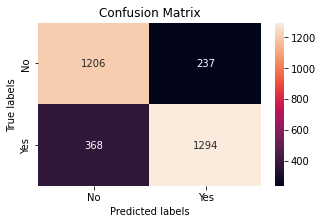

In [75]:
cm = confusion_matrix(log_pred, y_test)
f, ax= plt.subplots(1,1,figsize=(5,3))
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels') ; ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No', 'Yes']) ; ax.yaxis.set_ticklabels(['No', 'Yes'])

In [76]:
print('Accuracy',accuracy_score(log_pred, y_test))

Accuracy 0.8051529790660226


### Imbalance data

In [77]:
x_train_imb, x_test_imb, y_train_imb, y_test_imb = train_test_split(x, y, test_size=0.30, random_state=42)

In [78]:
logreg = LogisticRegression(random_state=42)
logreg.fit(x_train_imb, y_train_imb)

LogisticRegression(random_state=42)

In [79]:
y_pred_reg_imb = logreg.predict(x_test_imb)
y_pred_reg_imb

array([1, 0, 0, ..., 0, 1, 0])

[Text(0, 0.5, 'No'), Text(0, 1.5, 'Yes')]

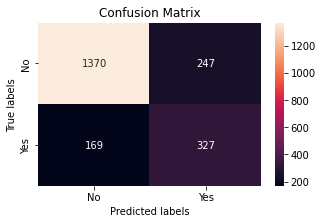

In [80]:
cm = confusion_matrix(y_pred_reg_imb, y_test_imb)
f, ax= plt.subplots(1,1,figsize=(5,3))
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels') ; ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No', 'Yes']) ; ax.yaxis.set_ticklabels(['No', 'Yes'])

## Modeling Random Forest

### Balance data

In [81]:
model = RandomForestClassifier(random_state=42)
model.fit(x_train, y_train)
preds_balance = model.predict(x_test)

### Metric Evaluation

[Text(0, 0.5, 'No'), Text(0, 1.5, 'Yes')]

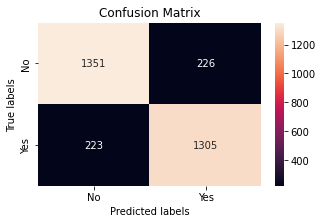

In [82]:
cm = confusion_matrix(preds_balance, y_test)
f, ax= plt.subplots(1,1,figsize=(5,3))
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels') ; ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No', 'Yes']) ; ax.yaxis.set_ticklabels(['No', 'Yes'])

In [83]:
print('Accuracy',accuracy_score(y_test, preds_balance))

Accuracy 0.8553945249597423


### Imbalance data

In [84]:
model = RandomForestClassifier(random_state=42)
model.fit(x_train_imb, y_train_imb)
preds_imbalance = model.predict(x_test_imb)

### Metric Evaluation

[Text(0, 0.5, 'No'), Text(0, 1.5, 'Yes')]

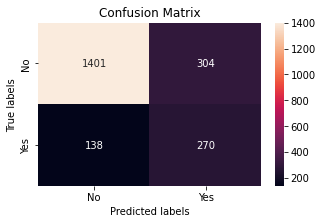

In [85]:
cm = confusion_matrix(preds_imbalance, y_test_imb)
f, ax= plt.subplots(1,1,figsize=(5,3))
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels') ; ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No', 'Yes']) ; ax.yaxis.set_ticklabels(['No', 'Yes'])

# Evaluation

## Logistic Regression

### Balance data

In [86]:
print('precision score:', precision_score(y_test, log_pred),'\n') 
print('recall score:',recall_score(y_test, log_pred),'\n')
print('AUC ', roc_auc_score(y_test, log_pred))
print(classification_report(y_test, log_pred, target_names=['No', 'Yes']))

precision score: 0.7785800240673887 

recall score: 0.8451992161985631 

AUC  0.8056999892936907
              precision    recall  f1-score   support

          No       0.84      0.77      0.80      1574
         Yes       0.78      0.85      0.81      1531

    accuracy                           0.81      3105
   macro avg       0.81      0.81      0.80      3105
weighted avg       0.81      0.81      0.80      3105



In [87]:
print('AUC ',roc_auc_score(y_test, log_pred))
print('F1 Score ',f1_score(y_test, log_pred))
print('Precision ',precision_score(y_test, log_pred))
print('Recall ',recall_score(y_test, log_pred))

AUC  0.8056999892936907
F1 Score  0.8105230191042906
Precision  0.7785800240673887
Recall  0.8451992161985631


Interpretation Log Reg Balance Data:

Accuracy = total accuracy 0.81

AUC = total 0.81

Precision = false positive 'No' is 0.84 and 'Yes' is 0.78

Recall = false negative 'No' is  0.77 and 'Yes' is 0.85

F1-score = Average between Precision dan Recall 'No' is 0.80 and 'Yes' is 0.81

### Imbalance data

In [88]:
print('precision score:', precision_score(y_test_imb, y_pred_reg_imb),'\n') 
print('recall score:',recall_score(y_test_imb, y_pred_reg_imb),'\n')
print('AUC ', roc_auc_score(y_test_imb, y_pred_reg_imb))
print(classification_report(y_test_imb, y_pred_reg_imb, target_names=['No', 'Yes']))

precision score: 0.6592741935483871 

recall score: 0.5696864111498258 

AUC  0.7299374225989544
              precision    recall  f1-score   support

          No       0.85      0.89      0.87      1539
         Yes       0.66      0.57      0.61       574

    accuracy                           0.80      2113
   macro avg       0.75      0.73      0.74      2113
weighted avg       0.80      0.80      0.80      2113



In [89]:
print('AUC ',roc_auc_score(y_test_imb, y_pred_reg_imb))
print('F1 Score ',f1_score(y_test_imb, y_pred_reg_imb))
print('Precision ',precision_score(y_test_imb, y_pred_reg_imb))
print('Recall ',recall_score(y_test_imb, y_pred_reg_imb))

AUC  0.7299374225989544
F1 Score  0.611214953271028
Precision  0.6592741935483871
Recall  0.5696864111498258


Interpretation Log Reg Imbalance Data:

Accuracy = total accuracy 0.80

AUC = total 0.729

Precision = false positive 'No' is 0.85 and 'Yes' is 0.66

Recall = false negative 'No' is  0.89 and 'Yes' is 0.57

F1-score = Average between Precision dan Recall 'No' is 0.87 and 'Yes' is 0.61

## Random Forest

### Balance data

In [90]:
print('precision score:', precision_score(y_test, preds_balance),'\n') 
print('recall score:',recall_score(y_test, preds_balance),'\n')
print('AUC ', roc_auc_score(y_test, preds_balance))
print(classification_report(y_test, preds_balance, target_names=['No', 'Yes']))

precision score: 0.8540575916230366 

recall score: 0.8523840627041149 

AUC  0.8553534036519305
              precision    recall  f1-score   support

          No       0.86      0.86      0.86      1574
         Yes       0.85      0.85      0.85      1531

    accuracy                           0.86      3105
   macro avg       0.86      0.86      0.86      3105
weighted avg       0.86      0.86      0.86      3105



In [91]:
print('AUC ',roc_auc_score(y_test, preds_balance))
print('F1 Score ',f1_score(y_test, preds_balance))
print('Precision ',precision_score(y_test, preds_balance))
print('Recall ',recall_score(y_test, preds_balance))

AUC  0.8553534036519305
F1 Score  0.8532200065380844
Precision  0.8540575916230366
Recall  0.8523840627041149


Interpretation Random Forest Balance Data:

Accuracy = total accuracy 0.86

AUC = total 0.85

Precision = false positive 'No' is 0.86 and 'Yes' is 0.85

Recall = false negative 'No' is  0.86 and 'Yes' is 0.85

F1-score = Average between Precision dan Recall 'No' is 0.86 and 'Yes' is 0.85

### Imbalance data

In [92]:
print('precision score:', precision_score(y_test_imb, preds_imbalance),'\n') 
print('recall score:',recall_score(y_test_imb, preds_imbalance),'\n')
print('AUC ', roc_auc_score(y_test_imb, preds_imbalance))
print(classification_report(y_test_imb, preds_imbalance, target_names=['No', 'Yes']))


precision score: 0.6617647058823529 

recall score: 0.47038327526132406 

AUC  0.6903573296384593
              precision    recall  f1-score   support

          No       0.82      0.91      0.86      1539
         Yes       0.66      0.47      0.55       574

    accuracy                           0.79      2113
   macro avg       0.74      0.69      0.71      2113
weighted avg       0.78      0.79      0.78      2113



In [ ]:
print('AUC ',roc_auc_score(y_test_imb, preds_imbalance))
print('F1 Score ',f1_score(y_test_imb, preds_imbalance))
print('Precision ',precision_score(y_test_imb, preds_imbalance))
print('Recall ',recall_score(y_test_imb, preds_imbalance))

AUC  0.6903573296384593
F1 Score  0.54989816700611
Precision  0.6617647058823529
Recall  0.47038327526132406


Interpretation Random Forest Imbalance Data:

Accuracy = total accuracy 0.79

AUC = total 0.69

Precision = false positive 'No' is 0.82 and 'Yes' is 0.66

Recall = false negative 'No' is  0.91 and 'Yes' is 0.47

F1-score = Average between Precision dan Recall 'No' is 0.86 and 'Yes' is 0.55

**Interpretation**: 

We split data based from imbalance and balance data, so we can see both either training model or accuracy evaluation. For this data, we would want high recall to better detecting customers who are in risk of churning. 
both models with balance data have given similiar score for recall. Random Forest (balance data) has bigger accuracy 0.88 score then it follow by 
Logistic Regression (balance data) with total accuracy 0.81 of detected churn from the models

**Overall**, ranking for best model 
Random forest balance data
Logistic Regression balance data
Logistic Regression imbalance data
Random forest imbalance data
